# Aim 

> This notebook does node classification for reddit users. It first creats a homogonous graph with users as nodes and edges as either users commenting to other users' posts or replying to messages. 

> Based on users' features (comment and link karmas), the average user upvotes (for posts and comments) are predicted. 

> GCN and GAT are compared along with fine tuning for different parameters.  

In [1]:
pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 9.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910476 sha256=fa072322124ce553d521f34abee727992d4c87501bb6c73b7fdb2933bec44a93
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


## Importing libraries

In [2]:
import pandas as pd 
import numpy as np
import collections

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.utils.convert import to_networkx
from torch_geometric.nn import GCNConv, SGConv

import networkx as nx

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/vanderbilt/social/project')

Mounted at /content/drive


## Data munging

In [4]:
users = pd.read_csv("users.csv", header= None)
edges = pd.read_csv("edges.csv", header = None)
df = pd.read_csv("df.csv", index_col = 0)

In [5]:
users = users.reset_index()

In [6]:
users.columns = ["userid", 'username']

In [7]:
users

,userid,username
0,0,that_90s_guy
1,1,AutoModerator
2,2,scumbagdetector15
3,3,csch2
4,4,PlayerofVideoGames
...,...,...
608,608,Lanky_Information825
609,609,xebeka6808
610,610,HumanJenoM
611,611,mvandemar


In [8]:
df

,comment_karma,link_karma,avg_upvotes
that_90s_guy,31343.0,20684.0,1503.390000
AutoModerator,1000.0,1000.0,1.004695
scumbagdetector15,18369.0,1.0,170.600000
csch2,1981.0,2622.0,136.000000
PlayerofVideoGames,18476.0,473.0,57.000000
...,...,...,...
Lanky_Information825,326.0,3.0,5.000000
xebeka6808,4631.0,765.0,5.000000
HumanJenoM,8117.0,505.0,3.000000
mvandemar,4467.0,2391.0,2.000000


In [9]:
node_features = df[["comment_karma", "link_karma"]]
num_classes = 2

In [10]:
node_features

,comment_karma,link_karma
that_90s_guy,31343.0,20684.0
AutoModerator,1000.0,1000.0
scumbagdetector15,18369.0,1.0
csch2,1981.0,2622.0
PlayerofVideoGames,18476.0,473.0
...,...,...
Lanky_Information825,326.0,3.0
xebeka6808,4631.0,765.0
HumanJenoM,8117.0,505.0
mvandemar,4467.0,2391.0


In [11]:
# Convert to numpy
x = torch.tensor(node_features.values)
x.shape # [num_nodes x num_features]

torch.Size([613, 2])

In [12]:
df

,comment_karma,link_karma,avg_upvotes
that_90s_guy,31343.0,20684.0,1503.390000
AutoModerator,1000.0,1000.0,1.004695
scumbagdetector15,18369.0,1.0,170.600000
csch2,1981.0,2622.0,136.000000
PlayerofVideoGames,18476.0,473.0,57.000000
...,...,...,...
Lanky_Information825,326.0,3.0,5.000000
xebeka6808,4631.0,765.0,5.000000
HumanJenoM,8117.0,505.0,3.000000
mvandemar,4467.0,2391.0,2.000000


In [13]:
median_upvotes = np.median(df.avg_upvotes) # dichotomizing upvotes

In [14]:
median_upvotes

3.0

In [15]:
labels = [1 if upvotes >= median_upvotes else 0 for upvotes in df['avg_upvotes']]

In [16]:
collections.Counter(labels) # balanced by design (median)

Counter({1: 334, 0: 279})

In [17]:
y = torch.tensor(labels, dtype=torch.long)
y.shape

torch.Size([613])

In [18]:
edges[['source', 'dest']] = edges[0].str.split("###", expand = True) # I added "###" while scraping from reddit

In [19]:
edges

,0,source,dest
0,AutoModerator###that_90s_guy,AutoModerator,that_90s_guy
1,scumbagdetector15###that_90s_guy,scumbagdetector15,that_90s_guy
2,csch2###scumbagdetector15,csch2,scumbagdetector15
3,scumbagdetector15###csch2,scumbagdetector15,csch2
4,PlayerofVideoGames###scumbagdetector15,PlayerofVideoGames,scumbagdetector15
...,...,...,...
1669,flossraptor###Alternative_Ad_9702,flossraptor,Alternative_Ad_9702
1670,Timofey_###Alternative_Ad_9702,Timofey_,Alternative_Ad_9702
1671,Alternative_Ad_9702###Alternative_Ad_9702,Alternative_Ad_9702,Alternative_Ad_9702
1672,xebeka6808###Alternative_Ad_9702,xebeka6808,Alternative_Ad_9702


In [20]:
edges = edges[['source', 'dest']]

In [21]:
edges['source']

0             AutoModerator
1         scumbagdetector15
2                     csch2
3         scumbagdetector15
4        PlayerofVideoGames
               ...         
1669            flossraptor
1670               Timofey_
1671    Alternative_Ad_9702
1672             xebeka6808
1673             xebeka6808
Name: source, Length: 1674, dtype: object

In [22]:
# Perform merge to obtain between users
edges_source_id = pd.merge(edges['source'], users,
                            left_on='source', right_on='username', how='left')

In [23]:
users

,userid,username
0,0,that_90s_guy
1,1,AutoModerator
2,2,scumbagdetector15
3,3,csch2
4,4,PlayerofVideoGames
...,...,...
608,608,Lanky_Information825
609,609,xebeka6808
610,610,HumanJenoM
611,611,mvandemar


In [24]:
edges_source_id = torch.from_numpy(edges_source_id['userid'].values)

In [25]:
edges_source_id

tensor([  1,   2,   3,  ..., 606, 609, 609])

In [26]:
edges_dest_id = pd.merge(edges['dest'], users,
                            left_on='dest', right_on='username', how='left')
edges_dest_id = torch.from_numpy(edges_dest_id['userid'].values)


In [27]:
edges_dest_id

tensor([  0,   0,   2,  ..., 606, 606, 606])

In [28]:
# # With this, we are ready to construct our `edge_index` in COO format
# # following PyG semantics:
edge_source_dest = torch.stack([edges_source_id, edges_dest_id], dim=0)

In [29]:
x = torch.tensor(x.float())
y = torch.tensor(y).ravel() # convert to 1D

<ipython-input-29-dc40f03e5e4c>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x.float())
<ipython-input-29-dc40f03e5e4c>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).ravel() # convert to 1D


In [30]:
y.shape

torch.Size([613])

## Graph creation

In [31]:
data = Data(x= x , edge_index=edge_source_dest, y=y, num_classes = 2) 

In [32]:
data

Data(x=[613, 2], edge_index=[2, 1674], y=[613], num_classes=2)

In [33]:
from torch_geometric.transforms import RandomNodeSplit as masking

Probably this is not the best way to split. Probably splitting using random links would be better

## setting seeds

In [34]:
import random

import numpy as np
from torch_geometric.seed import seed_everything
seed_everything(4)

In [35]:
msk=masking(split="train_rest", num_splits = 1, num_val = 0.2, num_test= 0.2) # creating a mask to split 
data=msk(data)
print(data)
print()
print("training samples",torch.sum(data.train_mask).item())
print("validation samples",torch.sum(data.val_mask ).item())
print("test samples",torch.sum(data.test_mask ).item())

# Hands-on Graph Neural Networks for Social Network Using PyTorch | by Awadelrahman M. A. Ahmed | Medium
# https://awadrahman.medium.com/hands-on-graph-neural-networks-for-social-network-using-pytorch-30231c130b38


Data(x=[613, 2], edge_index=[2, 1674], y=[613], num_classes=2, train_mask=[613], val_mask=[613], test_mask=[613])

training samples 367
validation samples 123
test samples 123


In [36]:
num_of_feat=data.num_node_features

In [37]:
num_of_feat

2

In [38]:
# class SocialGNN(torch.nn.Module):
#     def __init__(self,num_of_feat,f):
#         super(SocialGNN, self).__init__()
#         self.conv1 = GCNConv(num_of_feat, f)
#         self.conv2 = GCNConv(f, 2)
#     def forward(self, data):
#         x = data.x.float()
#         edge_index =  data.edge_index
#         x = self.conv1(x=x, edge_index=edge_index)
#         x = F.relu(x)
#         x = self.conv2(x, edge_index)
#         return x

In [39]:
# def masked_loss(predictions,labels,mask):
#     mask=mask.float()
#     mask=mask/torch.mean(mask)
#     loss=criterion(predictions,labels)
#     loss=loss*mask
#     loss=torch.mean(loss)
#     return (loss)    
# def masked_accuracy(predictions,labels,mask):
#     mask=mask.float()
#     mask/=torch.mean(mask)
#     accuracy=(torch.argmax(predictions,axis=1)==labels).long()
#     accuracy=mask*accuracy
#     accuracy=torch.mean(accuracy)
#     return (accuracy)

In [40]:
# def train_social(net,data,epochs=10,lr=0.01):
#     optimizer = torch.optim.Adam(net.parameters(), lr=lr) # 00001
#     best_accuracy=0.0
#     train_losses=[]
#     train_accuracies=[]
#     val_losses=[]
#     val_accuracies=[]
#     test_losses=[]
#     test_accuracies=[]
#     for ep in range(epochs+1):
#         # print(ep)
#         optimizer.zero_grad()
#         out=net(data)
#         loss=masked_loss(predictions=out,
#                          labels=data.y,
#                          mask=data.train_mask)
#         loss.backward()
#         optimizer.step()
#         train_losses+=[loss.detach().numpy()]
#         train_accuracy=masked_accuracy(predictions=out,
#                                        labels=data.y, 
#                                        mask=data.train_mask)
#         train_accuracies+=[train_accuracy]
#         val_loss=masked_loss(predictions=out,
#                              labels=data.y, 
#                              mask=data.val_mask)
#         # print(loss, val_loss)
#         val_losses+=[val_loss.detach().numpy()]
#         # print(val_losses)
#         val_accuracy=masked_accuracy(predictions=out,
#                                      labels=data.y, 
#                                      mask=data.val_mask)
#         val_accuracies+=[val_accuracy]
#         # test_accuracy=masked_accuracy(predictions=out,
#         #                               labels=data.y, 
#         #                               mask=data.test_mask)
#         # test_accuracies+=[test_accuracy]
#         if np.round(val_accuracy,4)> np.round(best_accuracy ,4):
#             # print("Epoch {}/{}, Train_Loss: {:.4f}, Train_Accuracy: {:.4f}, Val_Accuracy: {:.4f}, Test_Accuracy: {:.4f}"
#             #           .format(ep+1,epochs, loss.item(), train_accuracy, val_accuracy,  test_accuracy))
            
#             print("Epoch {}/{}, Train_Loss: {:.4f}, Train_Accuracy: {:.4f}, Val_Accuracy: {:.4f}"
#             .format(ep+1,epochs, loss.item(), train_accuracy, val_accuracy))

#             best_accuracy=val_accuracy
#     plt.plot(val_losses)
#     # plt.plot(train_losses)  
#     # plt.plot(test_losses)  
#     plt.show()
#     # plt.plot(train_accuracies) 
#     plt.plot(val_accuracies)
#     # plt.plot(test_accuracies) 
#     plt.show()

In [41]:
# net=SocialGNN(num_of_feat=num_of_feat,f=16)
# criterion=nn.CrossEntropyLoss()
# train_social(net,data,epochs=50,lr=0.1)

In [42]:
# from torch_geometric.utils import train_test_split_edges

# # Split the data into training, validation, and testing sets
# train_data, val_data, test_data = train_test_split_edges(data, val_ratio=0.05, test_ratio=0.1)


## GCN

In [80]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, Linear

class GCN(torch.nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, 16, dropout=dropout)
        self.conv2 = GCNConv(16, 1)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)


        return x.squeeze()

In [89]:
model = GCN(dropout = 0.6) # dropout needs to be added in the model instantiation 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)
# crit = torch.nn.BCELoss()
crit = F.binary_cross_entropy_with_logits

<function torch.nn.functional.binary_cross_entropy_with_logits(input: torch.Tensor, target: torch.Tensor, weight: Optional[torch.Tensor] = None, size_average: Optional[bool] = None, reduce: Optional[bool] = None, reduction: str = 'mean', pos_weight: Optional[torch.Tensor] = None) -> torch.Tensor>

In [82]:
model.train()
loss_values = []
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    # loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    # loss = crit(out[data.train_mask].squeeze(), data.y[data.train_mask].squeeze())
    loss = crit(out[data.train_mask], data.y[data.train_mask].float())

    loss_values.append(loss.item()) # to plot the training loss
    loss.backward()
    optimizer.step()

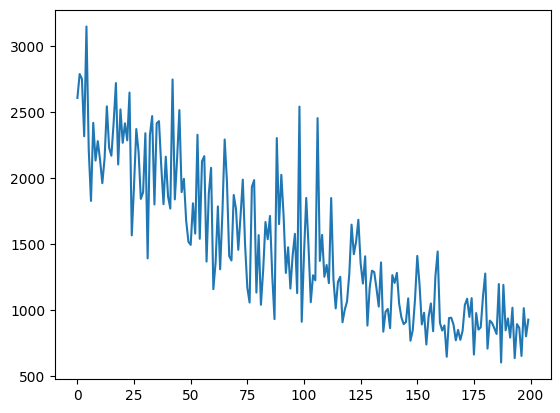

In [83]:
plt.plot(loss_values);

In [84]:
model.eval()
pred = model(data)
# setting a threshold of 0 for logits 
threshold = torch.tensor(0.0, dtype=torch.float32)
pred_labels =  torch.where(pred > threshold, 1, torch.zeros_like(pred)) # dichotomizing into 1 and 0
correct = (pred_labels[data.val_mask] == data.y[data.val_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')


Accuracy: 0.5772


In [85]:
# another way to calculate validation loss
model.eval()
with torch.no_grad():
    logits = model(data)
    pred_labels = torch.sigmoid(logits) > 0.5
    correct = pred_labels[data.val_mask].eq(data.y[data.val_mask]).sum().item()
    acc = correct / data.val_mask.sum().item()
    print(f'Accuracy: {acc:.4f}')


Accuracy: 0.5772


### Hyperparameter tuning  

- Number of layers:  1, 2, and also 5
- L2 regularization on the neural network weight matrices/parameters
(i.e., weight decay parameter: 0, 1e-4, and 1e-2)
- Learning rate given as input to torch.optim.Adam(): 1e-5 and 1e-2

I will calculate the mean and standard deviation of 3 runs 

#### 2 layers implemenattion

In [90]:
# Define the ranges for each hyperparameter
weight_decays = [0, 1e-4, 1e-2] 
learning_rates = [1e-5, 1e-2]
dropout_rates = [0, 0.2, 0.4, 0.6]

# Define the number of times to repeat for each set of hyperparameters
num_repeats = 3

# Initialize a dictionary to store the results
results = {}

# Loop over all possible combinations of hyperparameters
for weight_decay in weight_decays:
      for learning_rate in learning_rates:
          for dropout_rate in dropout_rates:
          
            # Initialize the model and optimizer with the current hyperparameters
            model = GCN(dropout = dropout_rate)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

            # Train the model and get the accuracy for each repeat
            acc_list = []
            for repeat in range(num_repeats):
                model.train()
                for epoch in range(200):
                    optimizer.zero_grad()
                    out = model(data)
                    loss = crit(out[data.train_mask], data.y[data.train_mask].float())
                    loss.backward()
                    optimizer.step()

                pred = model(data)
                # setting a threshold of 0 for logits 
                threshold = torch.tensor(0.0, dtype=torch.float32)
                pred_labels =  torch.where(pred > threshold, 1, torch.zeros_like(pred)) # dichotomizing into 1 and 0
                correct = (pred_labels[data.val_mask] == data.y[data.val_mask]).sum()
                acc = int(correct) / int(data.test_mask.sum())
                acc_list.append(acc)
                # print(f'Accuracy: {acc:.4f}')

            # Calculate the mean and standard deviation of accuracy for the current hyperparameters
            acc_mean = round(np.mean(acc_list),4)
            acc_std = round(np.std(acc_list),4)
            
            # Store the results in the dictionary
            results[(weight_decay,learning_rate, dropout_rate)] = (acc_mean, acc_std)


In [91]:
results

{(0, 1e-05, 0): (0.439, 0.0),
 (0, 1e-05, 0.2): (0.4715, 0.0115),
 (0, 1e-05, 0.4): (0.4932, 0.0383),
 (0, 1e-05, 0.6): (0.5447, 0.0176),
 (0, 0.01, 0): (0.5339, 0.0617),
 (0, 0.01, 0.2): (0.5041, 0.0654),
 (0, 0.01, 0.4): (0.5095, 0.0334),
 (0, 0.01, 0.6): (0.5285, 0.0674),
 (0.0001, 1e-05, 0): (0.4146, 0.0),
 (0.0001, 1e-05, 0.2): (0.5447, 0.0176),
 (0.0001, 1e-05, 0.4): (0.5203, 0.0404),
 (0.0001, 1e-05, 0.6): (0.6098, 0.0266),
 (0.0001, 0.01, 0): (0.439, 0.0066),
 (0.0001, 0.01, 0.2): (0.5637, 0.0203),
 (0.0001, 0.01, 0.4): (0.5881, 0.0167),
 (0.0001, 0.01, 0.6): (0.5691, 0.0239),
 (0.01, 1e-05, 0): (0.4309, 0.0),
 (0.01, 1e-05, 0.2): (0.4336, 0.0167),
 (0.01, 1e-05, 0.4): (0.5637, 0.0038),
 (0.01, 1e-05, 0.6): (0.5176, 0.0595),
 (0.01, 0.01, 0): (0.561, 0.0693),
 (0.01, 0.01, 0.2): (0.561, 0.0415),
 (0.01, 0.01, 0.4): (0.4634, 0.0176),
 (0.01, 0.01, 0.6): (0.5203, 0.023)}

#### One layer implementation 

In [93]:
class GCN_1(torch.nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, 1, dropout=dropout)
        self.dropout = dropout  # this 1 layer, no dropout will be applied

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)

        return x.squeeze()

In [94]:
# Define the ranges for each hyperparameter
weight_decays = [0, 1e-4, 1e-2] 
learning_rates = [1e-5, 1e-2]
dropout_rates = [0]

# Define the number of times to repeat for each set of hyperparameters
num_repeats = 3

# Initialize a dictionary to store the results
results_1L = {}

# Loop over all possible combinations of hyperparameters
for weight_decay in weight_decays:
      for learning_rate in learning_rates:
          for dropout_rate in dropout_rates:
          
            # Initialize the model and optimizer with the current hyperparameters
            model = GCN_1(dropout = dropout_rate)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

            # Train the model and get the accuracy for each repeat
            acc_list = []
            for repeat in range(num_repeats):
                model.train()
                for epoch in range(200):
                    optimizer.zero_grad()
                    out = model(data)
                    loss = crit(out[data.train_mask], data.y[data.train_mask].float())
                    loss.backward()
                    optimizer.step()

                pred = model(data)
                # setting a threshold of 0 for logits 
                threshold = torch.tensor(0.0, dtype=torch.float32)
                pred_labels =  torch.where(pred > threshold, 1, torch.zeros_like(pred)) # dichotomizing into 1 and 0
                correct = (pred_labels[data.val_mask] == data.y[data.val_mask]).sum()
                acc = int(correct) / int(data.test_mask.sum())
                acc_list.append(acc)
                # print(f'Accuracy: {acc:.4f}')

            # Calculate the mean and standard deviation of accuracy for the current hyperparameters
            acc_mean = round(np.mean(acc_list),4)
            acc_std = round(np.std(acc_list),4)
            
            # Store the results in the dictionary
            results_1L[(weight_decay,learning_rate, dropout_rate)] = (acc_mean, acc_std)


In [95]:
results_1L

{(0, 1e-05, 0): (0.439, 0.0),
 (0, 0.01, 0): (0.5718, 0.0038),
 (0.0001, 1e-05, 0): (0.561, 0.0),
 (0.0001, 0.01, 0): (0.542, 0.0755),
 (0.01, 1e-05, 0): (0.439, 0.0),
 (0.01, 0.01, 0): (0.5501, 0.0786)}

#### Five layers implementation 

In [98]:
class GCN_5(torch.nn.Module):
    def __init__(self, dropout = 0):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, 16, dropout=dropout)
        self.conv2 = GCNConv(16, 16, dropout=dropout)
        self.conv3 = GCNConv(16, 16, dropout=dropout)
        self.conv4 = GCNConv(16, 16, dropout=dropout)
        self.conv5 = GCNConv(16, 1)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p=self.dropout)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p=self.dropout)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p=self.dropout)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p=self.dropout)
        x = self.conv5(x, edge_index)

        return x.squeeze()

In [99]:
# Define the ranges for each hyperparameter
weight_decays = [0, 1e-4, 1e-2] 
learning_rates = [1e-5, 1e-2]
dropout_rates = [0, 0.2, 0.4, 0.6]

# Define the number of times to repeat for each set of hyperparameters
num_repeats = 3

# Initialize a dictionary to store the results
results_5L = {}

# Loop over all possible combinations of hyperparameters
for weight_decay in weight_decays:
      for learning_rate in learning_rates:
          for dropout_rate in dropout_rates:
          
            # Initialize the model and optimizer with the current hyperparameters
            model = GCN_5(dropout = dropout_rate)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

            # Train the model and get the accuracy for each repeat
            acc_list = []
            for repeat in range(num_repeats):
                model.train()
                for epoch in range(200):
                    optimizer.zero_grad()
                    out = model(data)
                    loss = crit(out[data.train_mask], data.y[data.train_mask].float())
                    loss.backward()
                    optimizer.step()

                pred = model(data)
                # setting a threshold of 0 for logits 
                threshold = torch.tensor(0.0, dtype=torch.float32)
                pred_labels =  torch.where(pred > threshold, 1, torch.zeros_like(pred)) # dichotomizing into 1 and 0
                correct = (pred_labels[data.val_mask] == data.y[data.val_mask]).sum()
                acc = int(correct) / int(data.test_mask.sum())
                acc_list.append(acc)
                # print(f'Accuracy: {acc:.4f}')

            # Calculate the mean and standard deviation of accuracy for the current hyperparameters
            acc_mean = round(np.mean(acc_list),4)
            acc_std = round(np.std(acc_list),4)
            
            # Store the results in the dictionary
            results_5L[(weight_decay,learning_rate, dropout_rate)] = (acc_mean, acc_std)


In [100]:
results_5L

{(0, 1e-05, 0): (0.439, 0.0),
 (0, 1e-05, 0.2): (0.4526, 0.0728),
 (0, 1e-05, 0.4): (0.4851, 0.048),
 (0, 1e-05, 0.6): (0.5366, 0.0479),
 (0, 0.01, 0): (0.5312, 0.0866),
 (0, 0.01, 0.2): (0.5447, 0.0239),
 (0, 0.01, 0.4): (0.5366, 0.0345),
 (0, 0.01, 0.6): (0.5447, 0.0115),
 (0.0001, 1e-05, 0): (0.5528, 0.0239),
 (0.0001, 1e-05, 0.2): (0.5583, 0.0038),
 (0.0001, 1e-05, 0.4): (0.4715, 0.0176),
 (0.0001, 1e-05, 0.6): (0.5203, 0.0465),
 (0.0001, 0.01, 0): (0.5908, 0.0503),
 (0.0001, 0.01, 0.2): (0.542, 0.0138),
 (0.0001, 0.01, 0.4): (0.5691, 0.0066),
 (0.0001, 0.01, 0.6): (0.561, 0.023),
 (0.01, 1e-05, 0): (0.5718, 0.0153),
 (0.01, 1e-05, 0.2): (0.5556, 0.0268),
 (0.01, 1e-05, 0.4): (0.4634, 0.0239),
 (0.01, 1e-05, 0.6): (0.5122, 0.037),
 (0.01, 0.01, 0): (0.6314, 0.0276),
 (0.01, 0.01, 0.2): (0.5528, 0.0304),
 (0.01, 0.01, 0.4): (0.5285, 0.0404),
 (0.01, 0.01, 0.6): (0.5501, 0.0192)}

#### Adding all results to a table

In [101]:
import pandas as pd
combined_dict = {}
combined_dict.update({1: results_1L})
combined_dict.update({2: results})
combined_dict.update({5: results_5L})

# Convert the dictionary into a pandas DataFrame
rows = []
for dict_type, inner_dict in combined_dict.items():
    for key, value in inner_dict.items():
        rows.append((dict_type, key, value[0], value[1]))

df = pd.DataFrame(rows, columns=['Layers', 'WD_LR_dropout', 'accuracy_mean', 'accuracy_std_dev'])

In [102]:
sorted_df = df.sort_values(by=['accuracy_mean'], ascending=False)
sorted_df

,Layers,WD_LR_dropout,accuracy_mean,accuracy_std_dev
50,5,"(0.01, 0.01, 0)",0.6314,0.0276
17,2,"(0.0001, 1e-05, 0.6)",0.6098,0.0266
42,5,"(0.0001, 0.01, 0)",0.5908,0.0503
20,2,"(0.0001, 0.01, 0.4)",0.5881,0.0167
46,5,"(0.01, 1e-05, 0)",0.5718,0.0153
1,1,"(0, 0.01, 0)",0.5718,0.0038
44,5,"(0.0001, 0.01, 0.4)",0.5691,0.0066
21,2,"(0.0001, 0.01, 0.6)",0.5691,0.0239
19,2,"(0.0001, 0.01, 0.2)",0.5637,0.0203
24,2,"(0.01, 1e-05, 0.4)",0.5637,0.0038


Best performance is for 1 layer, a weight decay of 0.0001, a learning rate of 1e-05 and a dropout rate of 0.6. It is worth noting that results are highly unstable. I am using the seed to avoid this. However, still the sample size is small

### Evaluate on the test data

In [104]:
# I will use the hyperparameters 0.01 and 0 weight decay and 2 layers and 0.2 dropout rate. Those hyperparameters were the best ones in a previous run. 
  

model = GCN(dropout = 0.2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0)

model.train()
loss_values = []
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = crit(out[data.train_mask], data.y[data.train_mask].float())

    loss_values.append(loss.item()) # to plot the training loss
    loss.backward()
    optimizer.step()


In [108]:
model.eval()
with torch.no_grad():
  pred = model(data)
  # setting a threshold of 0 for logits 
  threshold = torch.tensor(0.0, dtype=torch.float32)
  pred_labels =  torch.where(pred > threshold, 1, torch.zeros_like(pred)) # dichotomizing into 1 and 0
  correct = (pred_labels[data.test_mask] == data.y[data.test_mask]).sum()
  acc = int(correct) / int(data.test_mask.sum())
  print(f'Accuracy: {acc:.4f}')


Accuracy: 0.5203


It is worth noting that the sample size for the testing dataset is quite small. 

### Confusion matrix

In [109]:
from sklearn.metrics import confusion_matrix

In [111]:
cm = confusion_matrix(data.y[data.test_mask], pred_labels[data.test_mask])

In [112]:
import seaborn as sns 

In [113]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

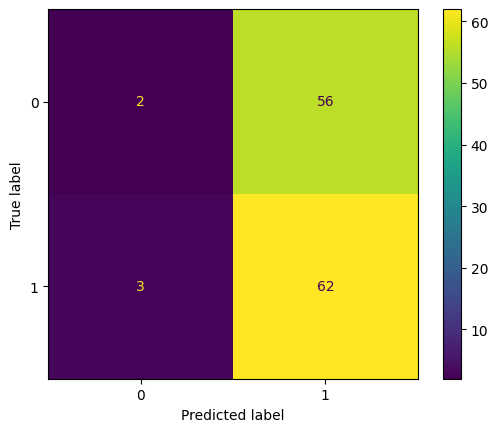

In [114]:
disp.plot();

The major problem is in false positives. Very low precision

In [ ]:
# K = 2
# class Net(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = SGConv(data.num_features, data.num_classes, K=2,
#                             cached=True)

#     def forward(self):
#         x, edge_index = data.x, data.edge_index
#         x = self.conv1(x, edge_index)
#         return x


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model, data = Net(), data
# optimizer = torch.optim.Adam(model.parameters(), lr=0.2, weight_decay=0.005)


# def train():
#     model.train()
#     optimizer.zero_grad()
#     crit(model()[data.train_mask], data.y[data.train_mask]).backward()
#     optimizer.step()


# @torch.no_grad()
# def test():
#     model.eval()
#     out, accs = model(), []
#     for _, mask in data('train_mask', 'val_mask', 'test_mask'):
#         pred = out[mask].argmax(1)
#         acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
#         accs.append(acc)
#     return accs


# best_val_acc = test_acc = 0
# for epoch in range(1, 101):
#     train()
#     train_acc, val_acc, tmp_test_acc = test()
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         test_acc = tmp_test_acc
#     print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, '
#           f'Val: {best_val_acc:.4f}, Test: {test_acc:.4f}')

In [ ]:
# K = 1
# class Net(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = SGConv(data.num_features, data.num_classes, K=1,
#                             cached=True)

#     def forward(self):
#         x, edge_index = data.x, data.edge_index
#         x = self.conv1(x, edge_index)
#         return x


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model, data = Net(), data
# optimizer = torch.optim.Adam(model.parameters(), lr=0.2, weight_decay=0.005)


# def train():
#     model.train()
#     optimizer.zero_grad()
#     crit(model()[data.train_mask], data.y[data.train_mask]).backward()
#     optimizer.step()


# @torch.no_grad()
# def test():
#     model.eval()
#     out, accs = model(), []
#     for _, mask in data('train_mask', 'val_mask', 'test_mask'):
#         pred = out[mask].argmax(1)
#         acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
#         accs.append(acc)
#     return accs


# best_val_acc = test_acc = 0
# for epoch in range(1, 101):
#     train()
#     train_acc, val_acc, tmp_test_acc = test()
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         test_acc = tmp_test_acc
#     print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, '
#           f'Val: {best_val_acc:.4f}, Test: {test_acc:.4f}')

In [ ]:
# # *K* = 3
# class Net(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = SGConv(data.num_features, data.num_classes, K=3,
#                             cached=True)

#     def forward(self):
#         x, edge_index = data.x, data.edge_index
#         x = self.conv1(x, edge_index)
#         return x


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model, data = Net(), data
# optimizer = torch.optim.Adam(model.parameters(), lr=0.2, weight_decay=0.005)


# def train():
#     model.train()
#     optimizer.zero_grad()
#     crit(model()[data.train_mask], data.y[data.train_mask]).backward()
#     optimizer.step()


# @torch.no_grad()
# def test():
#     model.eval()
#     out, accs = model(), []
#     for _, mask in data('train_mask', 'val_mask', 'test_mask'):
#         pred = out[mask].argmax(1)
#         acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
#         accs.append(acc)
#     return accs


# best_val_acc = test_acc = 0
# for epoch in range(1, 101):
#     train()
#     train_acc, val_acc, tmp_test_acc = test()
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         test_acc = tmp_test_acc
#     print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, '
#           f'Val: {best_val_acc:.4f}, Test: {test_acc:.4f}')

In [ ]:
# data.edge_index
# remove_percent = 0.25

# e = data.edge_index
# m = e.shape[1]
# keep = random.sample(range(m),int(m*(1-remove_percent)))
# e_reduced = e[:,keep]
# e_reduced.shape
# data.edge_index = e_reduced
# data.edge_index.shape
# model = GCN()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)

# model.train()
# loss_values = []
# for epoch in range(200):
#     optimizer.zero_grad()
#     out = model(data)
#     loss = crit(out[data.train_mask], data.y[data.train_mask])
#     loss_values.append(loss.item())
#     loss.backward()
#     optimizer.step()
# plt.plot(loss_values);
# ## LOOP :) 
# remove_percent = [0, 0.05, 0.25, 0.5, 0.95]

# for i in remove_percent: 
#   data = Data(x= x , edge_index=edge_source_dest, y=y, num_classes = 2)
#   msk=masking(split="train_rest", num_splits = 1, num_val = 0.2, num_test= 0.2)
#   data=msk(data)

#   e = data.edge_index
#   m = e.shape[1]
#   keep = random.sample(range(m),int(m*(1-i)))
#   e_reduced = e[:,keep]
#   print(e_reduced.shape[1])
#   data.edge_index = e_reduced
#   print(data.edge_index.shape[1])

#   model = GCN()
#   optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)

#   model.train()
#   loss_values = []
#   for epoch in range(200):
#       optimizer.zero_grad()
#       out = model(data)
#       loss = crit(out[data.train_mask], data.y[data.train_mask])
#       loss_values.append(loss.item())
#       loss.backward()
#       optimizer.step()
  
#   model.eval()
#   pred = model(data).argmax(dim=1)
#   correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
#   acc = int(correct) / int(data.val_mask.sum())
#   # print(f'Accuracy: {acc:.4f}')

#   plt.plot(loss_values, label= f'{i} -- Acc: {acc:.4f}' );


# plt.legend(title='Remove Percentage');


## GAT

In [116]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv

class GAT(torch.nn.Module):
    def __init__(self, dropout):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1
        self.dropout = dropout
        
        
        self.conv1 = GATConv(data.num_features, self.hid, heads=self.in_head, dropout=dropout)
        self.conv2 = GATConv(self.hid*self.in_head, 1, concat=False,
                             heads=self.out_head)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
                
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        
        return x.squeeze()
    
model = GAT(dropout = 0)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

model.train()
loss_values = []
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = crit(out[data.train_mask], data.y[data.train_mask].float())
    loss_values.append(loss.item())

    if epoch%200 == 0:
        print(loss)
    
    loss.backward()
    optimizer.step()

tensor(534.7745, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(15.3177, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(59.8428, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(50.0906, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(14.3590, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


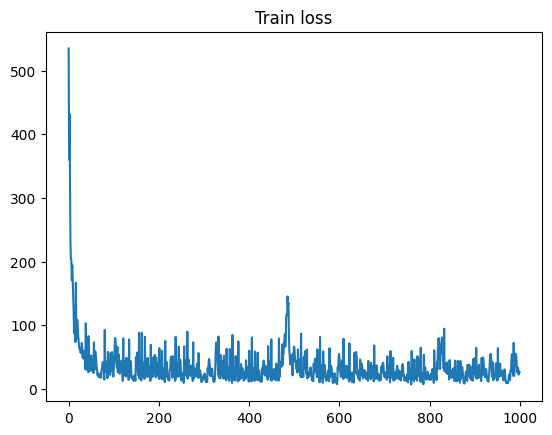

In [117]:
plt.plot(loss_values)
plt.title('Train loss');

In [118]:
model.eval()
pred = model(data)
# setting a threshold of 0 for logits 
threshold = torch.tensor(0.0, dtype=torch.float32)
pred_labels =  torch.where(pred > threshold, 1, torch.zeros_like(pred)) # dichotomizing into 1 and 0
correct = (pred_labels[data.val_mask] == data.y[data.val_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.4715


Slightly worse than GCN. Let's retry the hyperparameter tuning


### Hyperparameter tuning  

- Number of layers:  1, 2, and also 5
- L2 regularization on the neural network weight matrices/parameters
(i.e., weight decay parameter: 0, 1e-4, and 1e-2)
- Learning rate given as input to torch.optim.Adam(): 1e-5 and 1e-2
- Dropout (0, 0.2, 0.4, 0.6)

I will calculate the mean and standard deviation of 3 runs 

In [119]:
# Define the ranges for each hyperparameter
weight_decays = [0, 1e-4, 1e-2] 
learning_rates = [1e-5, 1e-2]
dropout_rates = [0, 0.2, 0.4, 0.6]

# Define the number of times to repeat for each set of hyperparameters
num_repeats = 3

# Initialize a dictionary to store the results
results = {}

# Loop over all possible combinations of hyperparameters
for weight_decay in weight_decays:
      for learning_rate in learning_rates:
          for dropout_rate in dropout_rates:
          
            # Initialize the model and optimizer with the current hyperparameters
            model = GAT(dropout = dropout_rate)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

            # Train the model and get the accuracy for each repeat
            acc_list = []
            for repeat in range(num_repeats):
                model.train()
                for epoch in range(200):
                    optimizer.zero_grad()
                    out = model(data)
                    loss = crit(out[data.train_mask], data.y[data.train_mask].float())
                    loss.backward()
                    optimizer.step()

                pred = model(data)
                # setting a threshold of 0 for logits 
                threshold = torch.tensor(0.0, dtype=torch.float32)
                pred_labels =  torch.where(pred > threshold, 1, torch.zeros_like(pred)) # dichotomizing into 1 and 0
                correct = (pred_labels[data.val_mask] == data.y[data.val_mask]).sum()
                acc = int(correct) / int(data.test_mask.sum())
                acc_list.append(acc)
                # print(f'Accuracy: {acc:.4f}')

            # Calculate the mean and standard deviation of accuracy for the current hyperparameters
            acc_mean = round(np.mean(acc_list),4)
            acc_std = round(np.std(acc_list),4)
            
            # Store the results in the dictionary
            results[(weight_decay,learning_rate, dropout_rate)] = (acc_mean, acc_std)


In [120]:
results

{(0, 1e-05, 0): (0.4309, 0.0),
 (0, 1e-05, 0.2): (0.4472, 0.023),
 (0, 1e-05, 0.4): (0.4661, 0.0406),
 (0, 1e-05, 0.6): (0.5285, 0.0304),
 (0, 0.01, 0): (0.5799, 0.0153),
 (0, 0.01, 0.2): (0.5393, 0.0769),
 (0, 0.01, 0.4): (0.5203, 0.0289),
 (0, 0.01, 0.6): (0.5285, 0.0465),
 (0.0001, 1e-05, 0): (0.6233, 0.0276),
 (0.0001, 1e-05, 0.2): (0.5447, 0.0115),
 (0.0001, 1e-05, 0.4): (0.4309, 0.023),
 (0.0001, 1e-05, 0.6): (0.4444, 0.0167),
 (0.0001, 0.01, 0): (0.5285, 0.0579),
 (0.0001, 0.01, 0.2): (0.5583, 0.0203),
 (0.0001, 0.01, 0.4): (0.5312, 0.0276),
 (0.0001, 0.01, 0.6): (0.5718, 0.0213),
 (0.01, 1e-05, 0): (0.5908, 0.0192),
 (0.01, 1e-05, 0.2): (0.5583, 0.0138),
 (0.01, 1e-05, 0.4): (0.5339, 0.0138),
 (0.01, 1e-05, 0.6): (0.5203, 0.0239),
 (0.01, 0.01, 0): (0.4824, 0.0881),
 (0.01, 0.01, 0.2): (0.5447, 0.0176),
 (0.01, 0.01, 0.4): (0.5718, 0.0268),
 (0.01, 0.01, 0.6): (0.542, 0.0299)}

In [121]:
df = pd.DataFrame.from_dict(results, orient='index')

df.reset_index(inplace = True)

df.columns = ['WD_LR_dropout', 'accuracy_mean', 'accuracy_std_dev']
df.sort_values("accuracy_mean", ascending = False)

,WD_LR_dropout,accuracy_mean,accuracy_std_dev
8,"(0.0001, 1e-05, 0)",0.6233,0.0276
16,"(0.01, 1e-05, 0)",0.5908,0.0192
4,"(0, 0.01, 0)",0.5799,0.0153
22,"(0.01, 0.01, 0.4)",0.5718,0.0268
15,"(0.0001, 0.01, 0.6)",0.5718,0.0213
13,"(0.0001, 0.01, 0.2)",0.5583,0.0203
17,"(0.01, 1e-05, 0.2)",0.5583,0.0138
21,"(0.01, 0.01, 0.2)",0.5447,0.0176
9,"(0.0001, 1e-05, 0.2)",0.5447,0.0115
23,"(0.01, 0.01, 0.6)",0.5420,0.0299


Similar performance to GCN. The best hyperparameters are 0.0001 weight decay, 1e-05 learning rate , and a dropout rate of 0

## Conclusion

> More sampele size is needed to enhance model performance and increase results stability. 

> GCN slightly outperforms GAT 

> More features are needed to better classify the nodes. Reddit is not offering a lot of features to be used. In addition, restricting our graphs to a single type of nodes (users) led to missing of multiple features. In a feature analysis, a heterogonous graph with users and posts/messages as nodes is possible. 

## References

Hands-on Graph Neural Networks for Social Network Using PyTorch | by Awadelrahman M. A. Ahmed | Medium
https://awadrahman.medium.com/hands-on-graph-neural-networks-for-social-network-using-pytorch-30231c130b38

Graph Neural Networks - YouTube
https://www.youtube.com/playlist?list=PLV8yxwGOxvvoNkzPfCx2i8an--Tkt7O8Z

Fake News Detection using Graphs with Pytorch Geometric - YouTube
https://www.youtube.com/watch?v=QAIVFr24FrA&list=PLV8yxwGOxvvoNkzPfCx2i8an--Tkt7O8Z&index=22

fake_news_detection.ipynb - Colaboratory
https://colab.research.google.com/drive/1ZVZdehPPod6o4sF64QZa8I3NoSOH8MmC?usp=sharing


Node Classification on Knowledge Graphs using PyTorch Geometric - YouTube
https://www.youtube.com/watch?v=ex2qllcVneY

knowledge_graphs_GNN.ipynb - Colaboratory
https://colab.research.google.com/drive/1LJir3T6M6Omc2Vn2GV2cDW_GV2YfI53_?usp=sharing#scrollTo=T8oB-KlJSaat

Tutorial Graph Neural Networks on Social Networks | Kaggle
https://www.kaggle.com/code/mahmoudhamza/tutorial-graph-neural-networks-on-social-networks/edit

Hands-on Graph Neural Networks with PyTorch & PyTorch Geometric | by Kung-Hsiang, Huang (Steeve) | Towards Data Science
https://towardsdatascience.com/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8